In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print("Is CUDA available: ", torch.cuda.is_available())
print("PyTorch version: ", torch.__version__)

Is CUDA available:  False
PyTorch version:  2.2.1+cu121


In [ ]:
class LandmarkDetectionCNN(nn.Module):
    def __init__(self):
        super(LandmarkDetectionCNN, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        self.convs = nn.Sequential(
            self.conv1,
            self.pool,
            self.conv2,
            self.pool,
            self.conv3,
            self.pool
        )
        # self._to_linear = None

        self.fc1 = nn.Linear(4*224*224, 1000)
        self.fc2 = nn.Linear(1000, 8)

    def forward(self, x):
        x = self.convs(x)

        # if self._to_linear is None:

            # self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            # self._to_linear = x.shape[0] * x.shape[1] * x.shape[2]

            # self.fc1 = nn.Linear(self._to_linear, 1000)
            # self.fc2 = nn.Linear(1000, 8)  # 4 landmarks * 2 coordinates = 8

        # if torch.cuda.is_available():
        #     self.fc1.cuda()
        #     self.fc2.cuda()

        x = x.view(-1, 4*224*224)  # Flattening the convs' outputs
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = LandmarkDetectionCNN()

In [ ]:
model = LandmarkDetectionCNN()#.to(device)
model_path = '/content/drive/MyDrive/Origin_Medical/final_landmark_detection_model.pth'
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

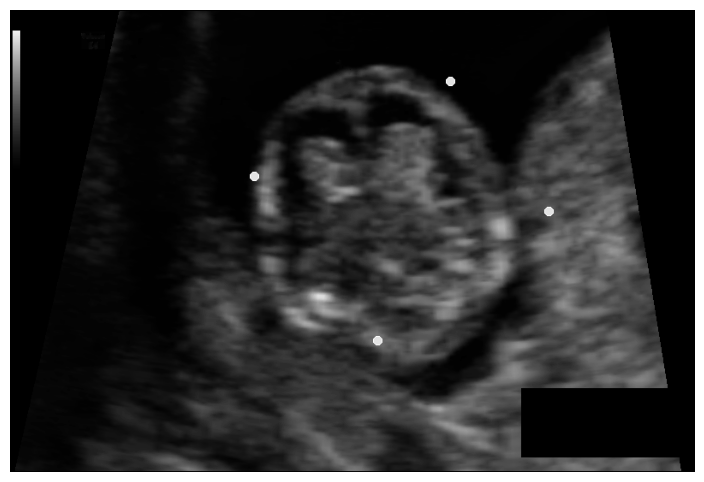

In [ ]:
def preprocess_image(image_path, transform=None):
    img_original = Image.open(image_path).convert('L')
    img_transformed = transform(img_original) if transform else img_original
    return img_original, img_transformed


def predict_points(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor.unsqueeze(0))
        predicted_points = outputs.cpu().numpy().flatten()  # Convert to numpy and flatten
    return predicted_points


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


image_path = '/content/drive/MyDrive/Origin_Medical/Task - Landmark/images/006_HC.png'
img_original, img_transformed = preprocess_image(image_path, transform)

# Predict biometry points on the transformed image
predicted_points = predict_points(model, img_transformed)

# Reshape and scale the predicted points
predicted_points = predicted_points.reshape(-1, 2)
original_width, original_height = img_original.size
scale_x = original_width / 224
scale_y = original_height / 224
scaled_points = [(x * scale_x, y * scale_y) for x, y in predicted_points]

# Visualize the predicted points on the original image
draw = ImageDraw.Draw(img_original)
for x, y in scaled_points:
    r = 5
    draw.ellipse((x - r, y - r, x + r, y + r), fill='yellow', outline='white')


plt.figure(figsize=(10, 6))
plt.imshow(img_original, cmap='gray')
plt.axis('off')
plt.show()
